Применим модель ARIMA для анализа курса валют

![ARIMA](1_12.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def smape(A, F):
    return 100*np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [3]:
data = pd.read_csv("https://video.ittensive.com/time-series/ittensive.time.series.02.csv",
                   delimiter=";", header=0, names=["Дата", "Курс", "Ипотека"])
data = data[::-1].reset_index().drop(labels="index", axis=1)
data.head()

,Дата,Курс,Ипотека
0,11.01.2022,75.1315,9.84
1,12.01.2022,74.8355,9.84
2,13.01.2022,74.5277,9.84
3,14.01.2022,74.5686,9.84
4,15.01.2022,75.7668,9.84


## Подбираем коэффициенты

Модель ARIMA использует три целочисленных параметра: p, d и q.

* p – порядок авторегрессии (AR). Его можно интерпретировать как выражение «элемент ряда будет близок к Х, если предыдущие р элементов были близки к Х».
* d – порядок интегрирования (I) разностей исходного временного ряда. Можно понимать как «элемент будет близок по значению к предыдущим d элементам, если их разность минимальна».
* q – порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

Найдем порядок автокорреляции (разностей исходного ряда)
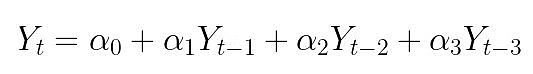

In [4]:
# ищем наибольший вклад компоненты в корреляцию по первым двум производным
data_ = data["Курс"]
pacf_coeff = np.zeros(22)
for p in range(1, 3):
    data_ = data_.diff().dropna()
    pacf_coeff += np.abs(pacf(data_))
pacf_coeff = list(pacf_coeff)
p_best = pacf_coeff.index(max(pacf_coeff))+1
print ("Порядок авторегрессии (AR) равен", p_best)

Порядок авторегрессии (AR) равен 1


In [5]:
# Проведем тест Дики-Фуллера на стационарность данных производных временного ряда для нахождения порядка интегрирования
data_ = data["Курс"]
d_best = 0
for d in range(1, 5):
    data_ = data_.diff().dropna()
    result = adfuller(data_)
    print ("p-значение для " + str(d) + "-производной ряда", result[1])
    if d_best == 0 and result[1] < 0.05:
        d_best = d
print ("d – порядок интегрирования (I) равен", d_best)

p-значение для 1-производной ряда 1.6475432053954344e-06
p-значение для 2-производной ряда 1.0121605641452392e-15
p-значение для 3-производной ряда 7.120990020402362e-11
p-значение для 4-производной ряда 2.315679323571737e-16
d – порядок интегрирования (I) равен 1


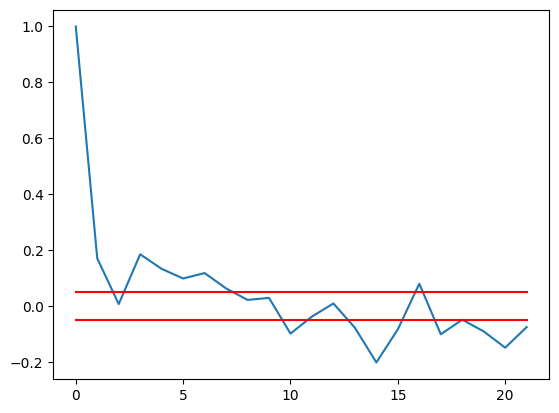

q – порядок скользящего среднего (MA) равен 2


In [6]:
# ищем порядок скользящего среднего (по вкладу компонентов первой производной)
q_best = 0
result = acf(data["Курс"].diff().dropna())
plt.plot(result)
plt.plot([0.05]*len(result), color="red")
plt.plot([-0.05]*len(result), color="red")
plt.show()
for i in range(len(result)):
    if abs(result[i]) > 0.05:
        q_best = i + 1
    else:
        break
print ("q – порядок скользящего среднего (MA) равен", q_best)

## Строим модель

In [7]:
model = ARIMA(data["Курс"], order=(p_best, d_best, q_best)).fit()
print (model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Курс   No. Observations:                  159
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -364.993
Date:                Wed, 16 Jul 2025   AIC                            737.987
Time:                        16:27:13   BIC                            750.237
Sample:                             0   HQIC                           742.962
                                - 159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8350      0.147      5.688      0.000       0.547       1.123
ma.L1         -0.6711      0.169     -3.973      0.000      -1.002      -0.340
ma.L2         -0.0555      0.058     -0.950      0.3

Переберем все коэффициенты "по сетке", выберем лучший вариант AIC

In [8]:
aic_best = model.aic
coeff_best = (p_best, d_best, q_best)
for p in range(1,5):
    for d in range(1,5):
        for q in range(1,5):
            model_ = ARIMA(data["Курс"], order=(p, d, q)).fit()
            aic = model_.aic
            if aic < aic_best:
                coeff_best = (p, d, q)
                aic_best = aic
print ("Наилучшие коффициенты:", coeff_best)

c:\Users\Samat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Samat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Samat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Samat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

Наилучшие коффициенты: (2, 1, 3)


c:\Users\Samat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Визуализация результата

In [9]:
model = ARIMA(data["Курс"][:-10], order=coeff_best).fit()
forecast = model.get_forecast(steps=10).predicted_mean

c:\Users\Samat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


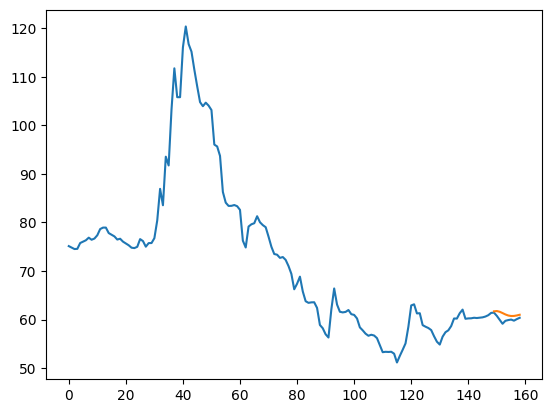

In [10]:
plt.plot(data["Курс"])
plt.plot(forecast)
plt.show()

Оценим ошибку

In [11]:
print ("Ошибка модели:", smape(data["Курс"][-10:], forecast))

Ошибка модели: 17.266644313500585


: 